In [17]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils
import src.model_selection as model_selection

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple test

In [64]:
np.random.seed(42)  # Seed for reproducibility
#real_graph = nx.gnp_random_graph(100, 0.05)  # G(n,p) model with 100 nodes and a probability of edge creation of 0.05
real_graph = nx.watts_strogatz_graph(n=100, k=4, p=0.1)

In [65]:
# Simulate a logistic graph model (another random graph, for demonstration purposes)
logit_graph = nx.erdos_renyi_graph(n=100, p=0.05)

In [66]:
# Importing the necessary class
import src.model_selection as ms 

# Initialize the RandomGraphModelSelector
selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


The best model is: WS
Model scores:
ER: 154.51379097017616
WS: 102.7709195710975
BA: 224.74150027837345
LG: 196.81372555526394


In [67]:
# Importing the necessary class
import src.model_selection as ms 

# Initialize the RandomGraphModelSelector
selector = ms.RandomGraphModelSelector(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


ER
For the Graph with 100 nodes and 214 edges i get the following scores: ks_stat: 0.24, cc_diff: 0.35166955266955263, aspl_diff: 1.421616161616162

WS
For the Graph with 100 nodes and 200 edges i get the following scores: ks_stat: 0.09, cc_diff: 0.06900000000000006, aspl_diff: 2.0242424242424244

BA
For the Graph with 100 nodes and 384 edges i get the following scores: ks_stat: 0.58, cc_diff: 0.18442751179436948, aspl_diff: 2.370505050505051

LG
For the Graph with 100 nodes and 238 edges i get the following scores: ks_stat: 0.4, cc_diff: 0.3190714285714285, aspl_diff: 1.5915151515151518

The best model is: ER
Model scores:
ER: 2.013285714285715
WS: 2.1832424242424247
BA: 3.1349325622994204
LG: 2.3105865800865804


# Celegans

In [73]:
import graph_tool.all as gt
from graph_tool.all import *

model = "celegans_2019/male_gap_junction" # undirected graph
g_celegans = gt.collection.ns[model]
g_celegans = adjacency(g_celegans)

spec_g_celegans = graph.GraphModel.calculate_spectrum(g_celegans)

AttributeError: 'Graph' object has no attribute 'GraphModel'

In [74]:
est = estimator.LogitRegEstimator2(g_celegans)
params, pval = est.estimate_parameters()
sigma,alpha,beta = params

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               170853
Model:                          Logit   Df Residuals:                   170850
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.1289
Time:                        14:20:14   Log-Likelihood:                -8511.9
converged:                       True   LL-Null:                       -9771.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9638      0.043   -137.522      0.000      -6.049      -5.879
x1             0.0844      0.002     46.396      0.000       0.081       0.088
x2             0.0743      0.002     38.430      0.0

## Gen graph with the same parameters

In [75]:
# beta should be higher than c
n = g_celegans.shape[0]
p = 0
alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6
threshold   = 0.5
n_iteration = 10
warm_up     = 5
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [76]:
graph = graph.GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration)

AttributeError: 'Graph' object has no attribute 'GraphModel'

In [77]:
ut = utils.GraphUtils()
ut.saving_graph_artifacts(params_dict, graphs, spec)
#graphs, spec = ut.loading_graph_artifacts(params_dict)

../data/input/graph_data_n=585_p=0_alpha=-0.0843557889967107_beta=-0.07429414968441728_sigma=5.963769941679803_threshold=0.5_n_iteration=10_warm_up=5.pickle
../data/input/spec_data_n=585_p=0_alpha=-0.0843557889967107_beta=-0.07429414968441728_sigma=5.963769941679803_threshold=0.5_n_iteration=10_warm_up=5.pickle


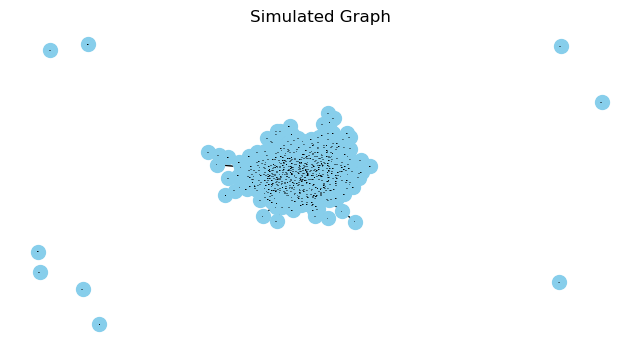

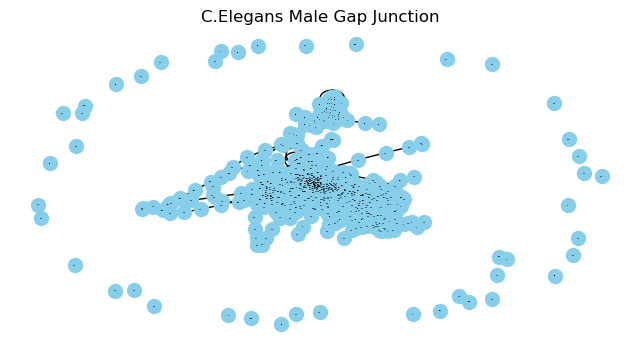

In [78]:
g = graphs[-1]
s = spec[-1]

fig1 = ut.plot_graph_from_adjacency(adj_matrix=g, pos=None, title='Simulated Graph', size=(8, 4), node_size=100, font_size=1)
fig2 = ut.plot_graph_from_adjacency(adj_matrix=g_celegans, pos=None, title='C.Elegans Male Gap Junction', size=(8, 4), node_size=100, font_size=1)

## Model Selections

In [79]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans.toarray())
logit_graph = nx.from_numpy_array(g)

selector = ms.RandomGraphModelSelector(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


ER
For the Graph with 585 nodes and 1746 edges i get the following scores: ks_stat: 0.29914529914529914, cc_diff: 0.19705158010520082, aspl_diff: 0

WS
For the Graph with 585 nodes and 1170 edges i get the following scores: ks_stat: 0.4461538461538462, cc_diff: 0.27465222416270607, aspl_diff: 0

BA
For the Graph with 585 nodes and 3474 edges i get the following scores: ks_stat: 0.6547008547008547, cc_diff: 0.13388363850118884, aspl_diff: 0

LG
For the Graph with 585 nodes and 1229 edges i get the following scores: ks_stat: 0.1794871794871795, cc_diff: 0.19820339125701197, aspl_diff: 0

The best model is: LG
Model scores:
ER: 0.49619687925049993
WS: 0.7208060703165522
BA: 0.7885844932020436
LG: 0.37769057074419143


In [80]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans.toarray())
logit_graph = nx.from_numpy_array(g)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


The best model is: LG
Model scores:
ER: 4.652814868537843
WS: 13.702000475541237
BA: 23.100967890079875
LG: 3.819704267074205


In [83]:
n_sim = 1000
results = []
for _ in range(n_sim):
    import src.model_selection as ms 
    real_graph = nx.from_numpy_array(g_celegans.toarray())
    logit_graph = nx.from_numpy_array(g)
    selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)
    best_model, model_scores = selector.fit()
    results.append(best_model)

In [82]:
from collections import Counter

counts = Counter(results)

# Plot 
plt.bar(counts.keys(), counts.values())
plt.xlabel('Model')
plt.ylabel('Count')
plt.title('Model counts')
plt.show()

['LG', 'LG', 'LG', 'LG', 'ER', 'LG', 'LG', 'LG', 'LG', 'LG']